In [1]:
from momentfm.data.anomaly_detection_dataset import AnomalyDetectionDataset

test_dataset = AnomalyDetectionDataset(data_split='test', random_seed=13)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


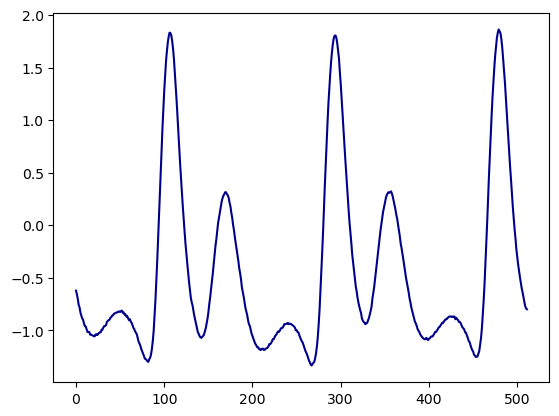

In [2]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(test_dataset))
plt.plot(test_dataset[idx][0].squeeze(), c='darkblue')
plt.show()

In [3]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [4]:
from dvats import utils as ut

In [5]:
timer = ut.Time()
timer.start()

1726649687.138984

In [6]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        "task_name": "forecasting",
        'forecast_horizon': 192,
        'head_dropout' : 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
    },
    # local_files_only = True,
)

In [7]:
model.init()

In [8]:
timer.end()
timer.duration

<bound method Time.duration of Time(time_start=1726649687.138984, time_end=1726649693.745234, time_total=6.606250047683716, function='')>

In [9]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


In [10]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512) #512 timesteps
output = model(x)
pprint(output)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=tensor([[[-0.0308,  0.0572, -0.0483,  ..., -0.0118, -0.0669, -0.1161]],

        [[ 0.1084,  0.0229, -0.1032,  ...,  0.0776,  0.0592,  0.0077]],

        [[ 0.0458, -0.0145, -0.1426,  ..., -0.0546, -0.1790, -0.1347]],

        ...,

        [[-0.0053,  0.0610, -0.0128,  ..., -0.0680, -0.1577,  0.0587]],

        [[ 0.1039,  0.0651,  0.0316,  ...,  0.0195,  0.0462,  0.0906]],

        [[ 0.1882,  0.0660, -0.0774,  ...,  0.0914,  0.0314,  0.0181]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [11]:
output.forecast.shape #batch x channels x window length

torch.Size([16, 1, 192])

Little training

MOMENT is pre-trained using a reconstruction head and a reconstruction head. To use MOMENT for forecasting, we replace the reconstruction head to a forecasting head. The forecasting head is a randomly initilized linear layer which maps MOMENT's embeddings to the forecasting horizon.

The forecasting head is randomly initialized, so it must be trained on your data.

In [12]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

In [13]:
! cp ~/data/ETTh1.csv ../data/ETTh1.csv

Para poder ejecutar el InformerDataset he tenido que modifiicar la linea cd ~/.local/lib/python3.10/site-packages/momentfm/informer_dataset.py 67 para que no use copy = False

In [14]:
# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [20]:
test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)

In [23]:
? test_dataset.data_source

Object ` test_dataset.data_source` not found.


In [22]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

ValueError: __len__() should return >= 0

In [ ]:
import torch
from tqdm import tqdm

model = model.to("cuda").float()

trues, preds, labels = [], [], []
with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_x = batch_x.to("cuda").float()
        batch_masks = batch_masks.to("cuda")

        output = model(batch_x, input_mask=batch_masks) # [batch_size, n_channels, window_size]

        trues.append(batch_x.detach().squeeze().cpu().numpy())
        preds.append(output.reconstruction.detach().squeeze().cpu().numpy())
        labels.append(batch_labels.detach().cpu().numpy())

In [ ]:
? output.embeddings

In [ ]:
import numpy as np

trues = np.concatenate(trues, axis=0).flatten()
preds = np.concatenate(preds, axis=0).flatten()
labels = np.concatenate(labels, axis=0).flatten()

# The last and the second to last windows have overlapping timesteps. We will remove these overlapping predictions
n_unique_timesteps = 512 - trues.shape[0] + test_dataset.length_timeseries
trues = np.concatenate([trues[:512*(test_dataset.length_timeseries//512)], trues[-n_unique_timesteps:]])
preds = np.concatenate([preds[:512*(test_dataset.length_timeseries//512)], preds[-n_unique_timesteps:]])
labels = np.concatenate([labels[:512*(test_dataset.length_timeseries//512)], labels[-n_unique_timesteps:]])
assert trues.shape[0] == test_dataset.length_timeseries

# We will use the Mean Squared Error (MSE) between the observed values and MOMENT's predictions as the anomaly score
anomaly_scores = (trues - preds)**2

In [ ]:
from momentfm.utils.anomaly_detection_metrics import adjbestf1

print(f"Zero-shot Adjusted Best F1 Score: {adjbestf1(y_true=labels, y_scores=anomaly_scores)}") 

In [ ]:
anomaly_start = 74158
anomaly_end = 74984
start = anomaly_start-512
end = anomaly_end+512

plt.plot(trues[start:end], label="Observed", c='darkblue')
plt.plot(preds[start:end], label="Predicted", c='red')
plt.plot(anomaly_scores[start:end], label="Anomaly Score", c='black')
plt.legend(fontsize=16)
plt.show()

In [ ]:
test_dataloader.dataset

In [ ]:
test_dataloader.dataset[0][0].shape
len (test_dataloader.dataset[0])

In [ ]:
len(test_dataloader.dataset)

In [ ]:
#dataset = np.array(test_dataloader.dataset)

In [ ]:
#dataset.shape

In [ ]:
inputs = []
for i in range (len(test_dataloader.dataset)):
    inputs.append(test_dataloader.dataset[i][0])

In [ ]:
enc_input = torch.from_numpy(np.array(inputs))

In [ ]:
enc_input.shape

In [ ]:
enc_input.to("cpu")
for i in range (len(test_dataloader.dataset)):
    enc_input[i].to("cpu").float()

In [ ]:
model.to("cpu")

In [ ]:
? enc_input

In [ ]:
enc_input.double()

In [ ]:
? enc_input

In [ ]:
? model 

In [ ]:
model.embed(  
    x_enc       = enc_input.float(), 
    input_mask  = None,
    reduction   = "mean"
)

In [ ]:
model.DataEmbedding

In [ ]:
embs = get_enc_embs(
    X          = test_dataloader.dataset, 
    enc_learn  = model, 
    cpu        = 'False', 
    to_numpy   = True,
    batch_size = enc_run.config['batch_size'],
    verbose    = 1
)